In [8]:
!pip install seaborn

    100% |████████████████████████████████| 215kB 82kB/s ta 0:00:01


In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from tqdm import tqdm#_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import os
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize



In [6]:
!pip install pandas

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms, utils

PATH = '../PKU/'
os.listdir(PATH)



['test_images',
 'EDA.ipynb',
 'camera.zip',
 'train_masks.zip',
 '.DS_Store',
 'test_images.zip',
 'train_images.zip',
 'car_models_json',
 'car_models_json.zip',
 'car_models',
 'camera_intrinsic.txt',
 'test_masks.zip',
 'train.csv',
 '.ipynb_checkpoints',
 'car_models.zip',
 'train_images',
 'test_masks',
 'train_masks',
 'train.csv.zip']

In [14]:
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'sample_submission.csv')

# From camera.zip
camera_matrix = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1]], dtype=np.float32)
camera_matrix_inv = np.linalg.inv(camera_matrix)

train.head()

ImageId                                   PredictionString
0  ID_8a6e65317  16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...
1  ID_337ddc495  66 0.163988 0.192169 -3.12112 -3.17424 6.55331...
2  ID_a381bf4d0  43 0.162877 0.00519276 -3.02676 2.1876 3.53427...
3  ID_7c4a3e0aa  43 0.126957 -3.04442 -3.10883 -14.738 24.6389 ...
4  ID_8b510fad6  37 0.16017 0.00862796 -3.0887 -3.04548 3.4977 ...

In [15]:
def str2coords(s, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
    '''
    Input:
        s: PredictionString (e.g. from train dataframe)
        names: array of what to extract from the string
    Output:
        list of dicts with keys from `names`
    '''
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords

In [18]:
!pip install imageio

    100% |████████████████████████████████| 3.3MB 149kB/s ta 0:00:011


In [21]:
from imageio import imread

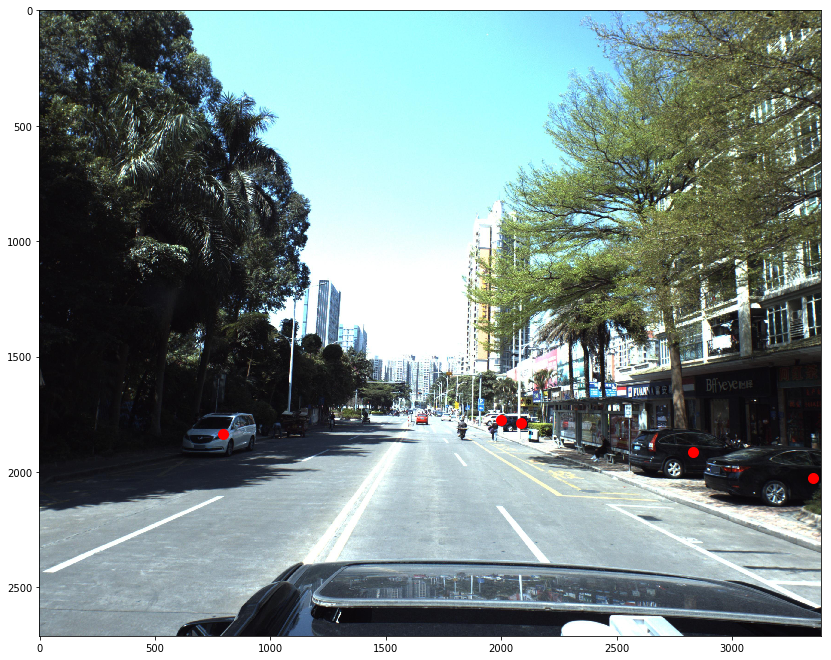

In [24]:
def get_img_coords(s):
    '''
    Input is a PredictionString (e.g. from train dataframe)
    Output is two arrays:
        xs: x coordinates in the image
        ys: y coordinates in the image
    '''
    coords = str2coords(s)
    xs = [c['x'] for c in coords]
    ys = [c['y'] for c in coords]
    zs = [c['z'] for c in coords]
    P = np.array(list(zip(xs, ys, zs))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_xs = img_p[:, 0]
    img_ys = img_p[:, 1]
    img_zs = img_p[:, 2] # z = Distance from the camera
    return img_xs, img_ys

plt.figure(figsize=(14,14))
plt.imshow(imread(PATH + 'train_images/' + train['ImageId'][0] + '.jpg'))
plt.scatter(*get_img_coords(train['PredictionString'][0]), color='red', s=100);

In [23]:
inp = train['PredictionString'][0]
print('Example input:\n', inp)
print()
print('Output:\n', str2coords(inp))

Example input:
 16 0.254839 -2.57534 -3.10256 7.96539 3.20066 11.0225 56 0.181647 -1.46947 -3.12159 9.60332 4.66632 19.339 70 0.163072 -1.56865 -3.11754 10.39 11.2219 59.7825 70 0.141942 -3.1395 3.11969 -9.59236 5.13662 24.7337 46 0.163068 -2.08578 -3.11754 9.83335 13.2689 72.9323

Output:
 [{'id': 16, 'yaw': 0.254839, 'pitch': -2.57534, 'roll': -3.10256, 'x': 7.96539, 'y': 3.20066, 'z': 11.0225}, {'id': 56, 'yaw': 0.181647, 'pitch': -1.46947, 'roll': -3.12159, 'x': 9.60332, 'y': 4.66632, 'z': 19.339}, {'id': 70, 'yaw': 0.163072, 'pitch': -1.56865, 'roll': -3.11754, 'x': 10.39, 'y': 11.2219, 'z': 59.7825}, {'id': 70, 'yaw': 0.141942, 'pitch': -3.1395, 'roll': 3.11969, 'x': -9.59236, 'y': 5.13662, 'z': 24.7337}, {'id': 46, 'yaw': 0.163068, 'pitch': -2.08578, 'roll': -3.11754, 'x': 9.83335, 'y': 13.2689, 'z': 72.9323}]


In [25]:
def visualize(img, coords):
    # You will also need functions from the previous cells
    x_l = 1.02
    y_l = 0.80
    z_l = 2.31
    
    img = img.copy()
    for point in coords:
        # Get values
        x, y, z = point['x'], point['y'], point['z']
        yaw, pitch, roll = -point['pitch'], -point['yaw'], -point['roll']
        # Math
        Rt = np.eye(4)
        t = np.array([x, y, z])
        Rt[:3, 3] = t
        Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
        Rt = Rt[:3, :]
        P = np.array([[x_l, -y_l, -z_l, 1],
                      [x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, -z_l, 1],
                      [0, 0, 0, 1]]).T
        img_cor_points = np.dot(camera_matrix, np.dot(Rt, P))
        img_cor_points = img_cor_points.T
        img_cor_points[:, 0] /= img_cor_points[:, 2]
        img_cor_points[:, 1] /= img_cor_points[:, 2]
        img_cor_points = img_cor_points.astype(int)
        # Drawing
        img = draw_line(img, img_cor_points)
        img = draw_points(img, img_cor_points[-1:])
    
    return img

In [29]:
def draw_line(image, points):
    color = (255, 0, 0)
    cv2.line(image, tuple(points[0][:2]), tuple(points[3][:2]), color, 16)
    cv2.line(image, tuple(points[0][:2]), tuple(points[1][:2]), color, 16)
    cv2.line(image, tuple(points[1][:2]), tuple(points[2][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[3][:2]), color, 16)
    return image


def draw_points(image, points):
    for (p_x, p_y, p_z) in points:
        cv2.circle(image, (p_x, p_y), int(1000 / p_z), (0, 255, 0), -1)
#         if p_x > image.shape[1] or p_y > image.shape[0]:
#             print('Point', p_x, p_y, 'is out of image with shape', image.shape)
    return image

In [30]:
from math import sin, cos

# convert euler angle to rotation matrix
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))

In [31]:
visualize(imread(PATH + 'train_images/' + train['ImageId'][0] + '.jpg'), str2coords(inp))

Array([[[ 63,  76,  85],
        [ 71,  83,  95],
        [ 78,  90, 104],
        ...,
        [134, 142,  82],
        [130, 136,  72],
        [125, 127,  62]],

       [[ 58,  71,  77],
        [ 64,  77,  85],
        [ 70,  82,  94],
        ...,
        [137, 145,  85],
        [134, 140,  76],
        [128, 133,  67]],

       [[ 53,  67,  68],
        [ 59,  73,  76],
        [ 65,  76,  82],
        ...,
        [137, 147,  87],
        [136, 144,  84],
        [132, 138,  74]],

       ...,

       [[132, 149, 156],
        [131, 148, 155],
        [130, 147, 154],
        ...,
        [  8,   6,   9],
        [  8,   6,   9],
        [  8,   6,   9]],

       [[132, 149, 156],
        [132, 149, 156],
        [131, 148, 155],
        ...,
        [  8,   6,   9],
        [  8,   6,   9],
        [  8,   6,   9]],

       [[133, 150, 157],
        [132, 149, 156],
        [131, 148, 155],
        ...,
        [  7,   5,   8],
        [  7,   5,   8],
        [  7,   5,   8]]

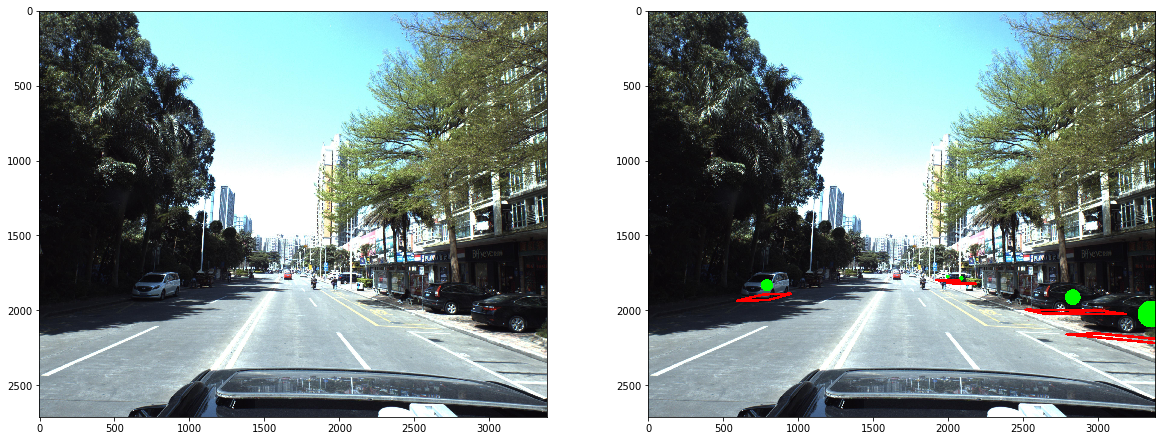

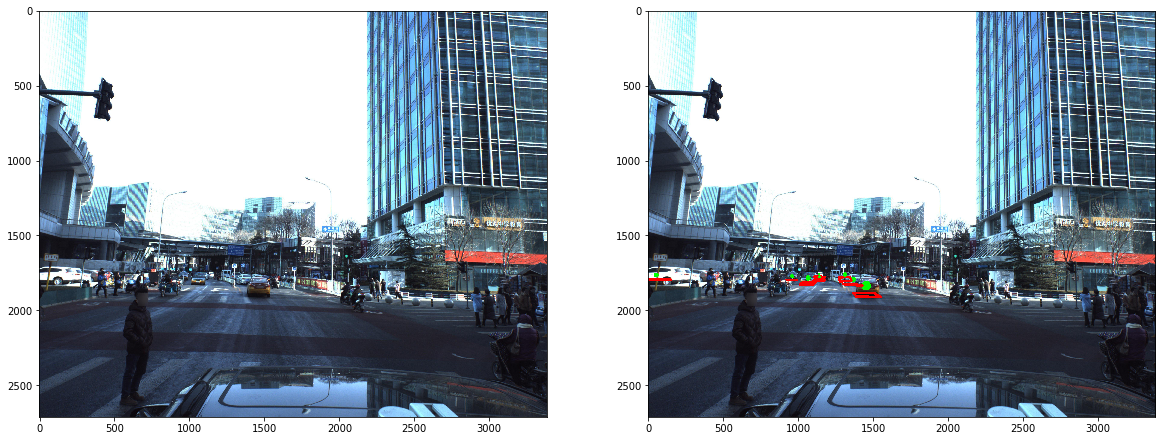

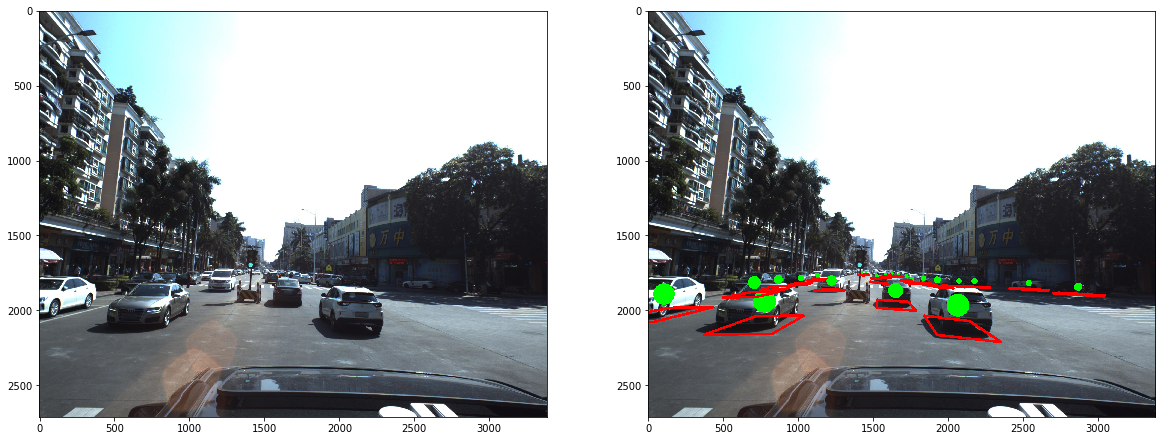

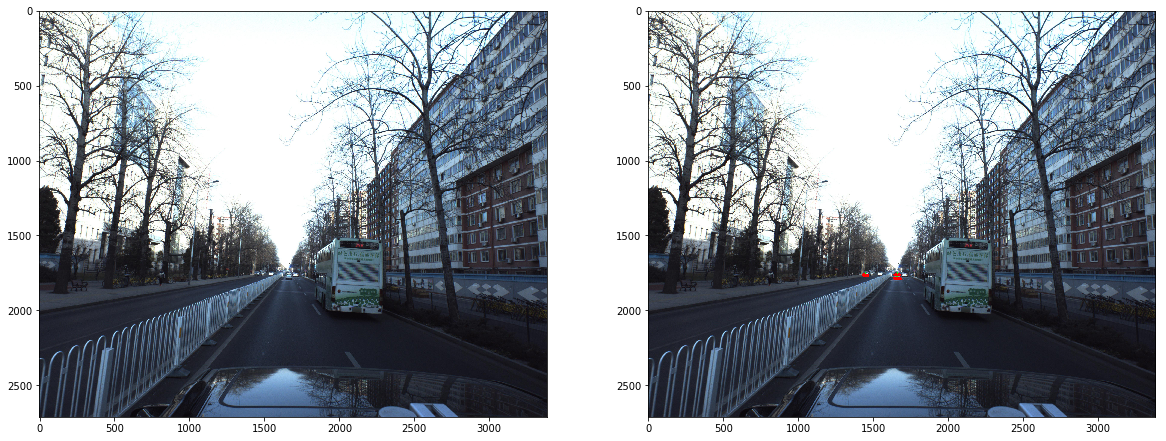

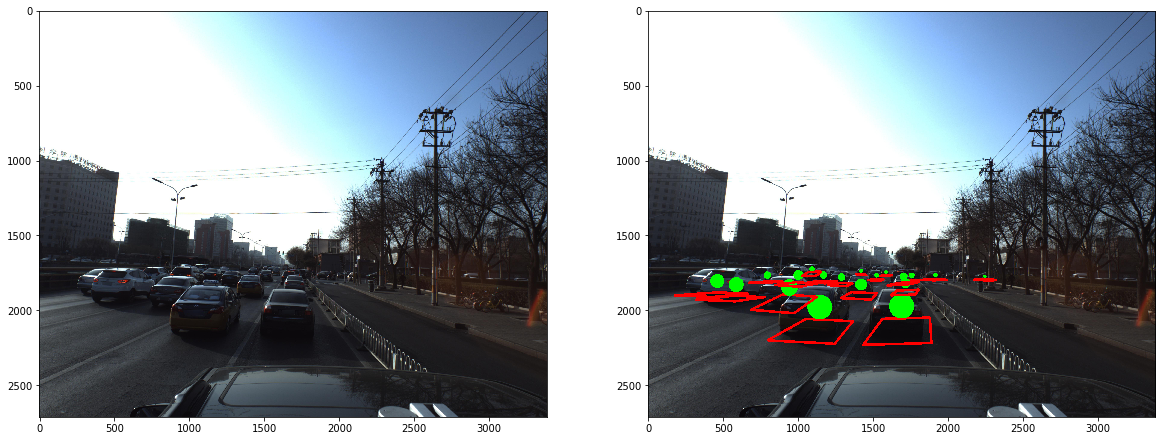

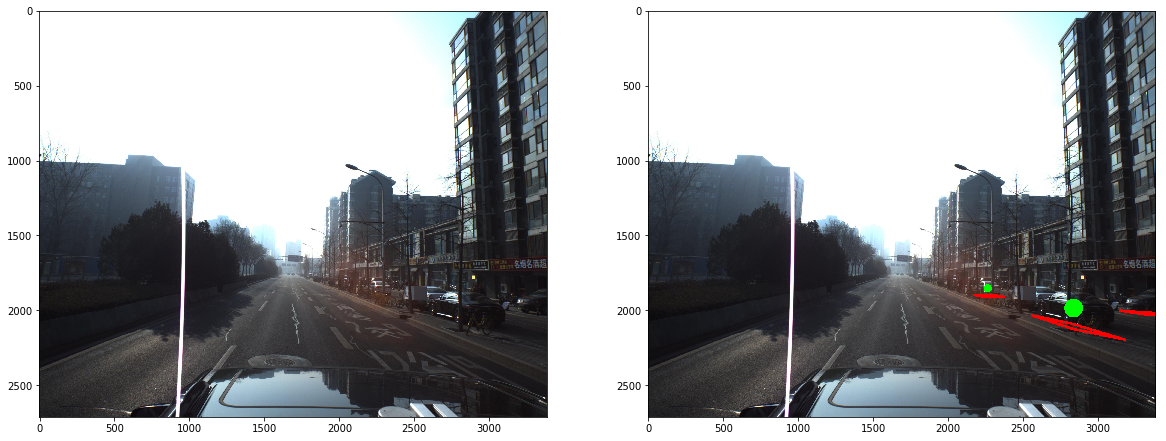

In [32]:
n_rows = 6

for idx in range(n_rows):
    fig, axes = plt.subplots(1, 2, figsize=(20,20))
    img = imread(PATH + 'train_images/' + train['ImageId'].iloc[idx] + '.jpg')
    axes[0].imshow(img)
    img_vis = visualize(img, str2coords(train['PredictionString'].iloc[idx]))
    axes[1].imshow(img_vis)
    plt.show()